In [2]:
import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >="2.0"

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation='nearest')
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis("off")

# What is a Convolution?

2023-06-30 23:43:38.464635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 23:43:38.520876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 23:43:38.521014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-30 23:43:38.521850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(-0.5, 639.5, 426.5, -0.5)

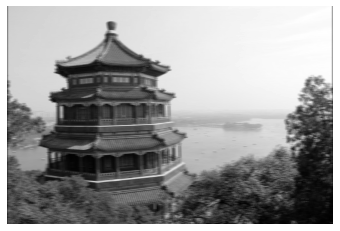

In [4]:
from sklearn.datasets import load_sample_image

china=load_sample_image("china.jpg")/255
flower=load_sample_image("flower.jpg")/255
images=np.array([china, flower])
batch_size, height, width, channels = images.shape

filters=np.zeros(shape=(7,7,channels, 2),dtype=np.float32)
filters[:,3,:,0] =1 # vertical line
filters[3,:,:,1] =1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0,:,:,1], cmap='gray')
plt.axis('off')

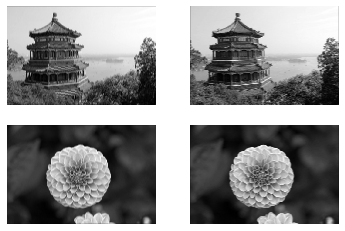

In [5]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2,2, image_index*2 + feature_map_index+1)
        plot_image(outputs[image_index,:,:,feature_map_index])


In [12]:
def crop(images):
    return images[150:220, 130:250]

china_original


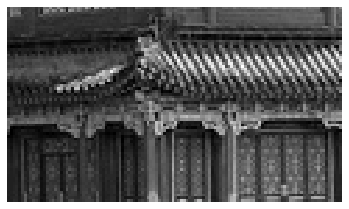

china_vertical


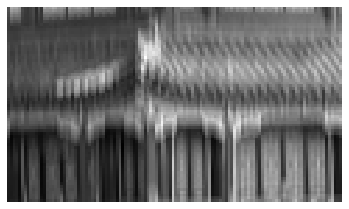

china_horizontal


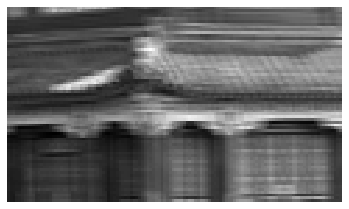

In [16]:
plot_image(crop(images[0,:,:,0]))
print('china_original')
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    print(filename)
    plot_image(crop(outputs[0,:,:,feature_map_index]))
    plt.show()

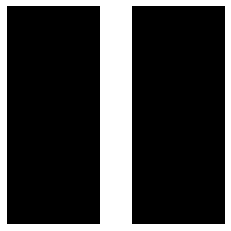

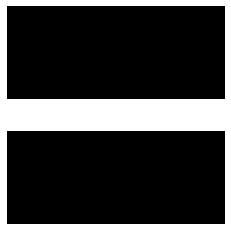

In [18]:
plot_image(filters[:,:,0,0])
plt.show()
plot_image(filters[:,:,0,1])
plt.show()

## Convolutional Layer

In [19]:
conv = keras.layers.Conv2D(filters =2, kernel_size=7, strides=1,
                          padding="SAME", activation='relu', input_shape=outputs.shape)

In [20]:
conv_outputs=conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

次元はバッチサイズ、高さ、幅、チャンネル。  
この畳込み層は2つのフィルターを持つのでチャンネルの次元数は2になる。

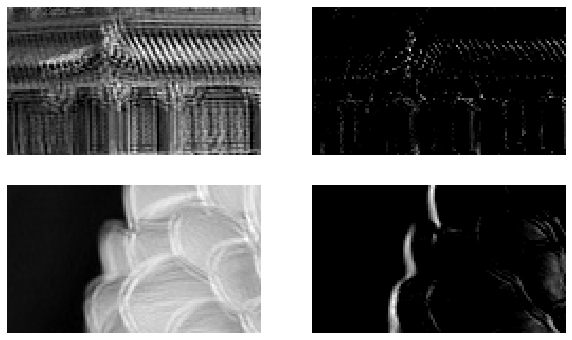

In [21]:
plt.figure(figsize =(10,6))
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2,2, image_index*2+feature_map_index+1 )
        plot_image(crop(conv_outputs[image_index, :,:,feature_map_index]))
plt.show()

In [22]:
conv.set_weights([filters, np.zeros(2)])

In [23]:
conv_outputs=conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

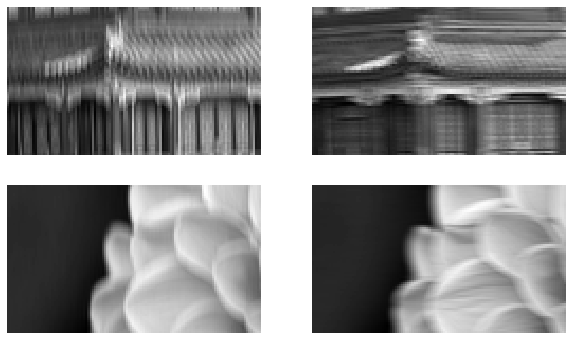

In [24]:
plt.figure(figsize =(10,6))
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2,2, image_index*2+feature_map_index+1 )
        plot_image(crop(conv_outputs[image_index, :,:,feature_map_index]))
plt.show() 

## VALID vs SAME padding

In [25]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding=='SAME':
        return (input_size-1)//strides +1
    else:
        return (input_size -kernel_size)//strides+1 

In [26]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size=feature_map_size(input_size, kernel_size, strides)
    padded_size=max((fmap_size -1)*strides + kernel_size, input_size)
    pad_before=(padded_size-input_size)//2
    return pad_before, padded_size

In [31]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size==1:
        return images.astype(np.float32)
    batch_size, height, width, channels=images.shape
    top_pad, padded_height=pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width=pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images=np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :]=images
    return padded_images

In [32]:
kernel_size =7
strides =2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

conv_same.build(tf.TensorShape(images.shape))

conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

## Max pooling

In [33]:
max_pool=keras.layers.MaxPool2D(pool_size=2)

In [34]:
cropped_images= np.array([crop(image) for image in images], dtype = np.float32)
output= max_pool(cropped_images)

(-0.5, 59.5, 34.5, -0.5)

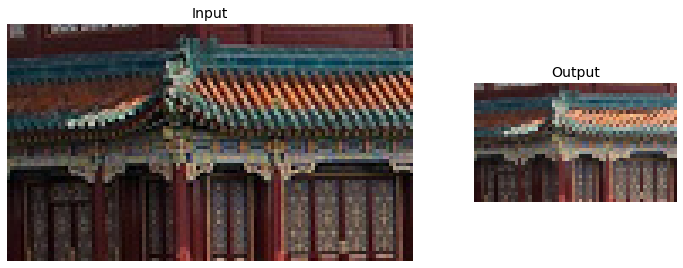

In [35]:
fig=plt.figure(figsize =(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])

ax1= fig.add_subplot(gs[0,0])
ax1.set_title('Input', fontsize =14)
ax1.imshow(cropped_images[0])
ax1.axis('off')
ax2= fig.add_subplot(gs[0,1])
ax2.set_title('Output', fontsize =14)
ax2.imshow(output[0])
ax2.axis('off')

## Depth-wise pooling

In [38]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides= strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                             ksize = (1,1,1, self.pool_size),
                             strides = (1, 1, 1, self.pool_size),
                             padding = self.padding)

In [39]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape


TensorShape([2, 70, 120, 1])

In [40]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize = (1,1,1,3), strides = (1,1,1,3), padding = 'VALID'))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape


TensorShape([2, 70, 120, 1])

(-0.5, 119.5, 69.5, -0.5)

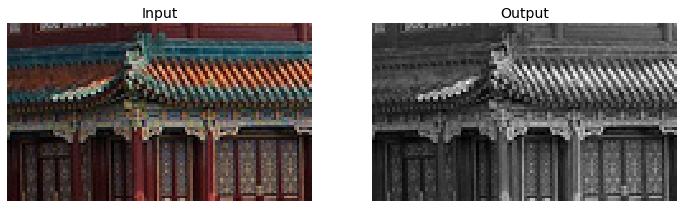

In [41]:
plt.figure(figsize= (12,6))
plt.subplot(1, 2,1)
plt.title("Input", fontsize =14)
plot_color_image(cropped_images[0])
plt.subplot(1,2,2)
plt.title("Output", fontsize =14)
plot_image(depth_output[0, ..., 0])
plt.axis('off')

## Average pooling

In [42]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [45]:
output_avg = avg_pool(cropped_images)

(-0.5, 59.5, 34.5, -0.5)

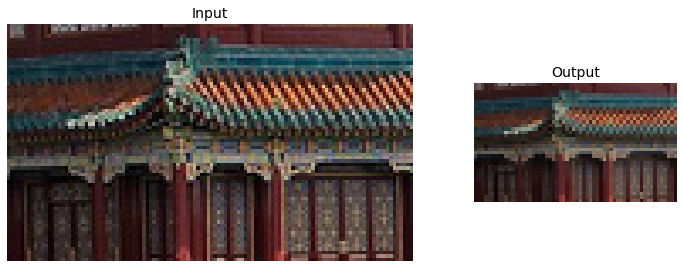

In [46]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])

ax1= fig.add_subplot(gs[0,0])
ax1.set_title('Input', fontsize =14)
ax1.imshow(cropped_images[0])
ax1.axis('off')
ax2= fig.add_subplot(gs[0,1])
ax2.set_title('Output', fontsize =14)
ax2.imshow(output_avg[0])
ax2.axis('off')

## Global Average Pooling

In [47]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [49]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1,2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

# Tackling Fashion MNIST With a CNN

In [50]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean= X_train.mean(axis=0, keepdims= True)
X_std =X_train.std(axis=0, keepdims= True)+ 1e-7
X_train= (X_train-X_mean)/X_std
X_valid= (X_valid-X_mean)/X_std
X_test= (X_test-X_mean)/X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [51]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding='SAME')

model=keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7,input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(pool_size =2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size =2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size =2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [52]:
model.compile(loss= 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new= X_test[:10]
y_pred=model.predict(X_new)

Epoch 1/10


2023-07-01 00:06:10.446658: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 11s 6ms/step - loss: 0.7177 - accuracy: 0.7461 - val_loss: 0.3819 - val_accuracy: 0.8584
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4300 - accuracy: 0.8560 - val_loss: 0.3308 - val_accuracy: 0.8804
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3704 - accuracy: 0.8738 - val_loss: 0.3316 - val_accuracy: 0.8858
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3383 - accuracy: 0.8880 - val_loss: 0.2954 - val_accuracy: 0.8912
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3121 - accuracy: 0.8941 - val_loss: 0.2832 - val_accuracy: 0.8952
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2900 - accuracy: 0.9011 - val_loss: 0.3069 - val_accuracy: 0.8926
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2805 - accuracy: 0.9043 - val_loss: 0.2738 - val_accuracy: 0.9016
Ep

## ResNet-34

In [58]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                       padding='SAME', use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides =1, activation ="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides= strides),
            keras.layers.BatchNormalization(),
            self.activation, 
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers=[]
        if strides >1 :
            self.skip_layers =[
                DefaultConv2D(filters, kernel_size =1, strides =strides),
                keras.layers.BatchNormalization()]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z=layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z=layer(skip_Z)
        return self.activation(Z+skip_Z)

In [59]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides =2,
                        input_shape=[224,224,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2,padding="SAME"))
prev_filters = 64
for filters in [64 ]*3 +[128] * 4 + [256]* 6+[512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = 'softmax'))


In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

## Using a Pretrained Model

In [61]:
model=keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 4s 0us/step


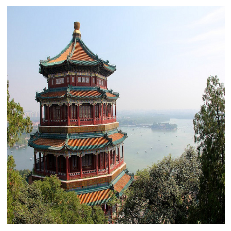

In [65]:
images_resized=tf.image.resize(images, [224,224])
plot_color_image(images_resized[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


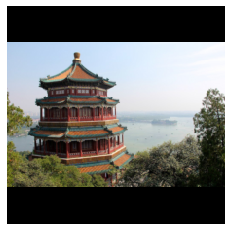

In [68]:
images_resized=tf.image.resize_with_pad(images, 224,224, antialias=True)
plot_color_image(images_resized[0])

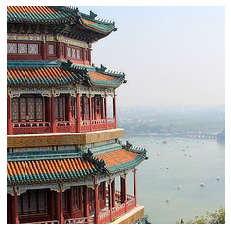

In [69]:
images_resized=tf.image.resize_with_crop_or_pad(images, 224,224)
plot_color_image(images_resized[0])

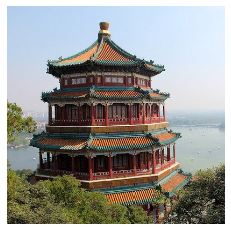

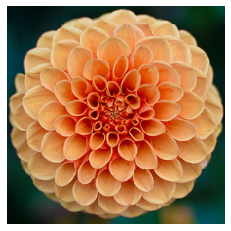

In [71]:
china_box=[0,0.03,1,0.68]
flower_box=[0.19,0.26,0.86,0.7]
images_resized=tf.image.crop_and_resize(images,[china_box,flower_box],[0,1],[224,224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [72]:
inputs=keras.applications.resnet50.preprocess_input(images_resized*255)
Y_proba=model.predict(inputs)

1/1 [==============================] - 1s 766ms/step


In [73]:
Y_proba.shape

(2, 1000)

In [74]:
top_K=keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba*100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #0
 n03877845 - palace       43.36%
 n02825657 - bell_cote    43.09%
 n03781244 - monastery    11.71%

Image #1
 n04522168 - vase         53.94%
 n07930864 - cup          9.52%
 n11939491 - daisy        4.97%



## Pretrained Models for Transfer Learning

In [77]:
import tensorflow_datasets as tfds

dataset, info =tfds.load("tf_flowers", as_supervised=True, with_info=True)

2023-07-01 00:22:35.390629: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/tuffy/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [78]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [79]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [80]:
class_names=info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [81]:
n_classes =info.features["label"].num_classes

In [82]:
dataset_size = info.splits["train"].num_examples

In [83]:
test_set_raw, valid_set_raw, train_set_raw =tfds.load(
    "tf_flowers", 
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

2023-07-01 00:22:53.895416: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


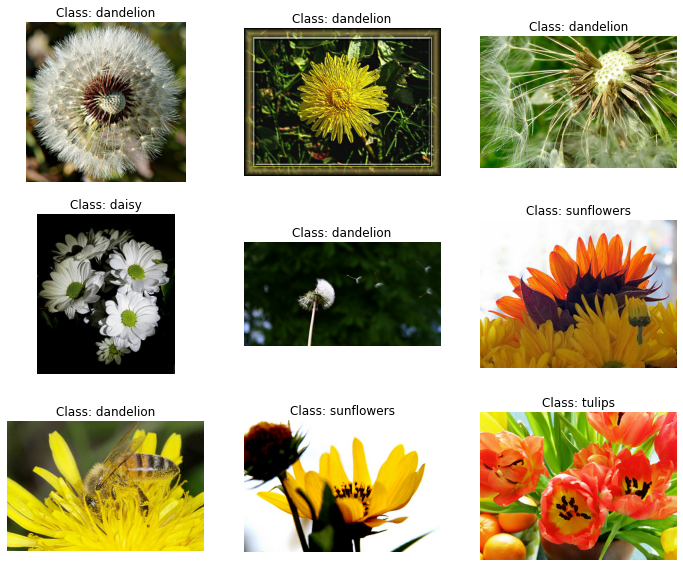

In [84]:
plt.figure(figsize=(12,10))
index = 0
for image, label in train_set_raw.take(9):
    index+=1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis('off')

In [85]:
def preprocess(image, label):
    resized_image= tf.image.resize(image, [224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [86]:
def central_crop(image):
    shape= tf.shape(image)
    min_dim = tf.reduce_min([shape[0],shape[1]])
    top_crop = (shape[0] - min_dim)//4
    bottom_crop=shape[0] - top_crop
    left_crop = (shape[1]- min_dim)//4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape= tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])* 90//100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize= False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image=tf.image.resize(cropped_image, [224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size =32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)


2023-07-01 00:22:58.923555: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


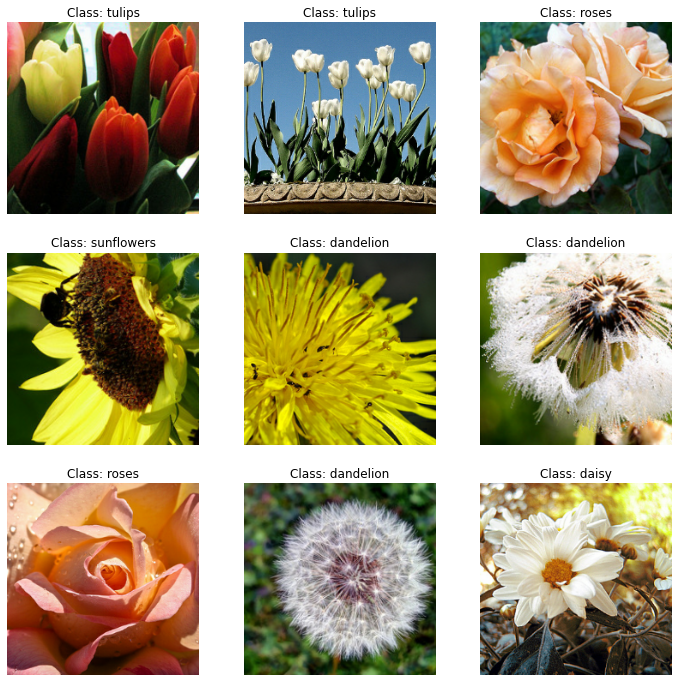

In [87]:
plt.figure(figsize = (12,12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index]/ 2 +0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

2023-07-01 00:22:59.316258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


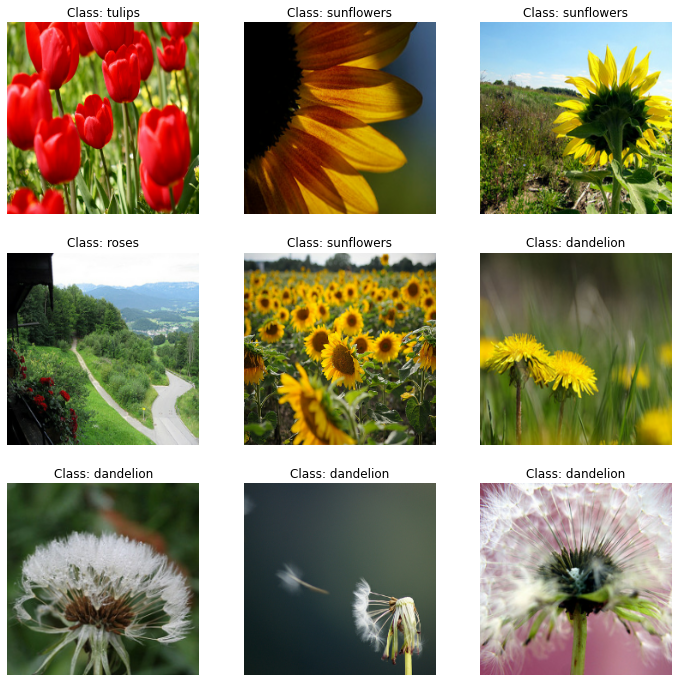

In [88]:
plt.figure(figsize = (12,12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index]/ 2 +0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

In [89]:
base_model = keras.applications.xception.Xception(weights ="imagenet", include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation= "softmax")(avg)
model = keras.models.Model(inputs= base_model.input, outputs = output)

83683744/83683744 [==============================] - 3s 0us/step


In [90]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_50
13 block2_pool
14 batch_normalization_38
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_51
23 block3_pool
24 batch_normalization_39
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_52
33 block4_pool
34 batch_normalization_40
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [93]:
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.SGD(learning_rate= 0.2, momentum = 0.9 , decay = 0.01)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch = int(0.75*dataset_size/batch_size),
                    validation_data = valid_set,
                    validation_steps= int(0.15*dataset_size/batch_size),
                    epochs =5)

Epoch 1/5
86/86 [==============================] - 10s 86ms/step - loss: 0.9677 - accuracy: 0.8136 - val_loss: 0.8744 - val_accuracy: 0.8456
Epoch 2/5
86/86 [==============================] - 7s 81ms/step - loss: 0.5060 - accuracy: 0.8903 - val_loss: 0.6725 - val_accuracy: 0.8787
Epoch 3/5
86/86 [==============================] - 7s 81ms/step - loss: 0.3063 - accuracy: 0.9262 - val_loss: 0.6432 - val_accuracy: 0.8897
Epoch 4/5
86/86 [==============================] - 7s 81ms/step - loss: 0.2179 - accuracy: 0.9360 - val_loss: 0.6581 - val_accuracy: 0.8695
Epoch 5/5
86/86 [==============================] - 7s 81ms/step - loss: 0.1613 - accuracy: 0.9506 - val_loss: 0.5763 - val_accuracy: 0.8805


In [95]:
for layer in base_model.layers:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9,
                                 nesterov =True, decay =0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer,
              metrics = ["accuracy"])
history = model.fit(train_set, 
                    steps_per_epoch = int(0.75*dataset_size/batch_size),
                    validation_data = valid_set,
                    validation_steps= int(0.15*dataset_size/batch_size),
                    epochs =40)

Epoch 1/40
86/86 [==============================] - 37s 392ms/step - loss: 0.3268 - accuracy: 0.8943 - val_loss: 0.5326 - val_accuracy: 0.8474
Epoch 2/40
86/86 [==============================] - 33s 385ms/step - loss: 0.1208 - accuracy: 0.9608 - val_loss: 0.2731 - val_accuracy: 0.9154
Epoch 3/40
86/86 [==============================] - 33s 387ms/step - loss: 0.0759 - accuracy: 0.9742 - val_loss: 0.3072 - val_accuracy: 0.9283
Epoch 4/40
86/86 [==============================] - 33s 388ms/step - loss: 0.0558 - accuracy: 0.9826 - val_loss: 0.3556 - val_accuracy: 0.9062
Epoch 5/40
86/86 [==============================] - 34s 391ms/step - loss: 0.0388 - accuracy: 0.9880 - val_loss: 0.2810 - val_accuracy: 0.9191
Epoch 6/40
86/86 [==============================] - 33s 384ms/step - loss: 0.0265 - accuracy: 0.9891 - val_loss: 0.2655 - val_accuracy: 0.9246
Epoch 7/40
86/86 [==============================] - 33s 389ms/step - loss: 0.0252 - accuracy: 0.9902 - val_loss: 0.2272 - val_accuracy: 0.9375

# Classification and Localization

In [96]:
base_model = keras.applications.xception.Xception(weights= "imagenet", include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation= "softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs= base_model.input, outputs = [class_output, loc_output])
model.compile(loss = ["sparse_categorical_crossentropy", "mse"], 
              loss_weights=[0.8,0.2],
              optimizer = optimizer, metrics=["accuracy"])

In [98]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes= tf.random.uniform([tf.shape(images)[0],4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [99]:
model.fit(fake_train_set, steps_per_epoch=5, epochs =2)

Epoch 1/2
5/5 [==============================] - 4s 366ms/step - loss: 1.3532 - dense_5_loss: 1.6068 - dense_6_loss: 0.3389 - dense_5_accuracy: 0.2875 - dense_6_accuracy: 0.2062
Epoch 2/2
5/5 [==============================] - 2s 355ms/step - loss: 1.3483 - dense_5_loss: 1.6090 - dense_6_loss: 0.3058 - dense_5_accuracy: 0.2625 - dense_6_accuracy: 0.2562


## Mean Average Precision (mAP)

In [100]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

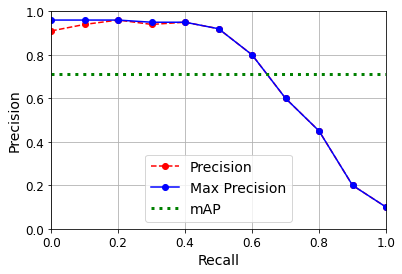

In [101]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions= maximum_precisions(precisions)
mAP=max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label = "Precision")
plt.plot(recalls, max_precisions, "bo-", label = "Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0,1], [mAP, mAP], "g:", linewidth=3, label ="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc = "lower center", fontsize =14)

In [102]:
tf.random.set_seed(42)
X= images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters =5, kernel_size = 3, strides=2, padding="VALID")
output= conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

(-0.5, 448.5, 448.5, -0.5)

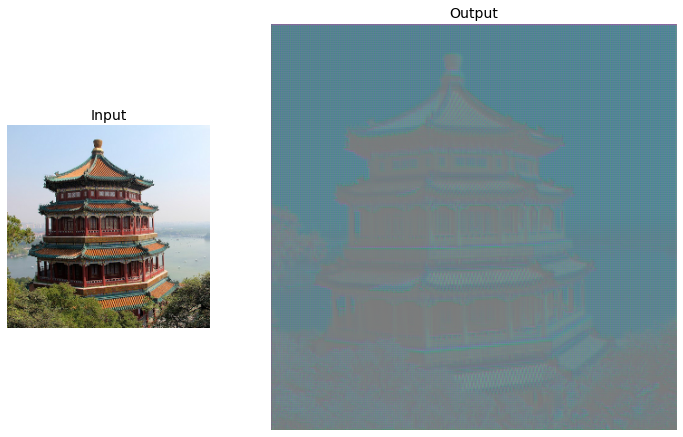

In [105]:
def normalize(X):
    return (X- tf.reduce_min(X))/(tf.reduce_max(X) -tf.reduce_min(X))
    
fig = plt.figure(figsize = (12,8))
gs = mpl.gridspec.GridSpec(nrows= 1, ncols=2, width_ratios =[1,2])

ax1= fig.add_subplot(gs[0,0])
ax1.set_title("Input", fontsize =14)
ax1.imshow(X[0])
ax1.axis("off")
ax2= fig.add_subplot(gs[0,1])
ax2.set_title("Output", fontsize =14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")
ax2.axis("off")

In [108]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled= np.zeros((batch_size,
                       (height -1)*stride+2*kernel_size -1, 
                       (width -1) * stride+2*kernel_size-1, 
                       channels))
    upscaled[:,
             kernel_size-1:(height-1)*stride+kernel_size:stride,
             kernel_size-1:(width-1)*stride+kernel_size:stride,
             :] = images
    return upscaled

In [109]:
upscaled= upscale_images(X, stride=2, kernel_size =3)
weights, biases = conv_transpose.weights
reversed_filters =np.flip(weights.numpy(), axis = [0,1])
reversed_filters =np.transpose(reversed_filters, [0,1,3,2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides =1, padding="VALID")


(-0.5, 448.5, 448.5, -0.5)

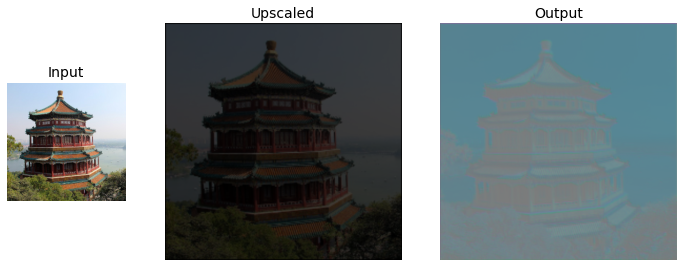

In [110]:
def normalize(X):
    return (X- tf.reduce_min(X))/ (tf.reduce_max(X)-tf.reduce_min(X))

fig = plt.figure(figsize= (12,8))
gs= mpl.gridspec.GridSpec(nrows= 1, ncols=3, width_ratios =[1,2,2])

ax1= fig.add_subplot(gs[0,0])
ax1.set_title("Input",fontsize=14)
ax1.imshow(X[0])
ax1.axis('off')
ax2= fig.add_subplot(gs[0,1])
ax2.set_title("Upscaled",fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis('off')
ax3= fig.add_subplot(gs[0,2])
ax3.set_title("Output",fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")
ax3.axis('off')

In [111]:
np.allclose(output, manual_output.numpy(), atol =1e-7)

True